# MKYZ Quick Start Guide

Get up and running with MKYZ in 5 minutes.

This notebook covers the essential workflow of MKYZ: loading data, training models (manually and automatically), evaluating results, and exporting reports.

## 1. Import MKYZ

In [1]:
import mkyz

mkyz package initialized. Version: 0.2.1


## 2. Load Your Data

MKYZ provides two ways to load and prepare your data for machine learning.

### Option A: Using `prepare_data` (Original API)
Automatically handles loading, splitting, scaling, and encoding in one go.

In [2]:
# Automatically handles everything
data = mkyz.prepare_data(
    'data/titanic.csv',
    target_column='Survived',
    test_size=0.2,
    random_state=42
)

# Returns a tuple: X_train, X_test, y_train, y_test, df, target, num_cols, cat_cols
X_train, X_test, y_train, y_test, df, target, num_cols, cat_cols = data

print(f"X_train shape: {X_train.shape}")

INFO:mkyz.data_processing:First 5 rows of the dataset:
INFO:mkyz.data_processing:   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803 

X_train shape: (576, 1420)


### Option B: Using `load_data` (New API)
More flexible loading and validation.

In [3]:
# More flexible loading
df = mkyz.load_data('data/titanic.csv')  # Also supports .xlsx, .json, .parquet

# Validate the dataset
validation = mkyz.validate_dataset(df, target_column='Survived')
print(validation)

{'is_valid': True, 'issues': [], 'warnings': ["Columns with missing values: {'Age': np.int64(177), 'Cabin': np.int64(687), 'Embarked': np.int64(2)}"], 'statistics': {'n_rows': 891, 'n_columns': 12, 'memory_usage_mb': np.float64(0.3076438903808594), 'missing_values': {'Age': np.int64(177), 'Cabin': np.int64(687), 'Embarked': np.int64(2)}, 'total_missing': np.int64(866)}}


## 3. Train a Model

### Single Model Training
Train a specific model using the `data` tuple.

In [4]:
# Train a Random Forest classifier
model = mkyz.train(
    data,
    task='classification',
    model='rf',
    n_estimators=100
)

### AutoML - Find the Best Model
Automatically train all supported models and find the best one.

In [5]:
# Automatically train all models and find the best one
"""
best_model = mkyz.auto_train(
    data,
    task='classification',
    n_threads=4,               # Parallel training
    optimize_models=True,      # Hyperparameter tuning
    optimization_method='grid_search'  # or 'bayesian'
)
"""

"\nbest_model = mkyz.auto_train(\n    data,\n    task='classification',\n    n_threads=4,               # Parallel training\n    optimize_models=True,      # Hyperparameter tuning\n    optimization_method='grid_search'  # or 'bayesian'\n)\n"

## 4. Make Predictions

In [6]:
predictions = mkyz.predict(data, model, task='classification')

## 5. Evaluate Performance

### Quick Evaluation

In [7]:
scores = mkyz.evaluate(data, predictions, task='classification')
print(scores)

{'accuracy': 0.7862068965517242, 'f1_score': 0.7751644980952852, 'precision': 0.784191670398567, 'recall': 0.7862068965517242, 'roc_auc': 0.7278947368421053}


### Detailed Metrics

In [8]:
from mkyz import classification_metrics

metrics = classification_metrics(y_test, predictions)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

accuracy: 0.7862
precision: 0.7842
recall: 0.7862
f1_score: 0.7752
mcc: 0.5063
cohen_kappa: 0.4907


### Cross-Validation

In [9]:
from mkyz import cross_validate, CVStrategy

results = cross_validate(
    model, X_train, y_train,
    cv=CVStrategy.STRATIFIED,
    n_splits=5
)

print(f"Mean accuracy: {results['mean_test_score']:.4f}")
print(f"Std: {results['std_test_score']:.4f}")

Mean accuracy: 0.8177
Std: 0.0149


## 6. Save Your Model

In [10]:
# Save with metadata
import os
if not os.path.exists('models'):
    os.makedirs('models')

mkyz.save_model(
    model,
    'models/my_model',
    format='joblib',
    metadata={'accuracy': 0.95, 'version': '1.0'}
)

'c:\\Users\\mmust\\Desktop\\mkyz\\examples\\models\\my_model.joblib'

## 7. Load and Use Later

In [11]:
# Load the model
loaded_model, metadata = mkyz.load_model(
    'models/my_model.joblib',
    return_metadata=True
)

print(f"Model metadata: {metadata}")

# Make predictions with loaded model (using sklearn API directly)
new_predictions = loaded_model.predict(X_test)

Model metadata: {'accuracy': 0.95, 'version': '1.0', 'loaded_at': '2026-01-15T19:56:19.819475', 'saved_at': '2026-01-15T19:56:17.484992', 'mkyz_version': '0.2.1'}


## 8. Generate a Report

In [12]:
from mkyz import ModelReport

# Create comprehensive report
report = ModelReport(
    model=model,
    X_test=X_test,
    y_test=y_test,
    task='classification',
    model_name='Random Forest Classifier'
)

# Generate report
report.generate()

# Print summary
print(report.summary())

# Export to HTML
if not os.path.exists('reports'):
    os.makedirs('reports')
report.export_html('reports/model_report.html')

Model Report: Random Forest Classifier
Task: Classification
Samples: 145
Features: 1420

Metrics:
----------------------------------------
  accuracy: 0.7862
  precision: 0.7842
  recall: 0.7862
  f1_score: 0.7752
  mcc: 0.5063
  cohen_kappa: 0.4907
  roc_auc: 0.8346

Top 10 Features:
----------------------------------------
  1. feature_724: 0.0869
  2. feature_725: 0.0827
  3. feature_2: 0.0576
  4. feature_0: 0.0501
  5. feature_1: 0.0448
  6. feature_1406: 0.0246
  7. feature_1347: 0.0234
  8. feature_1405: 0.0157
  9. feature_1413: 0.0104
  10. feature_1403: 0.0097


'c:\\Users\\mmust\\Desktop\\mkyz\\examples\\reports\\model_report.html'

## 9. Visualize Results

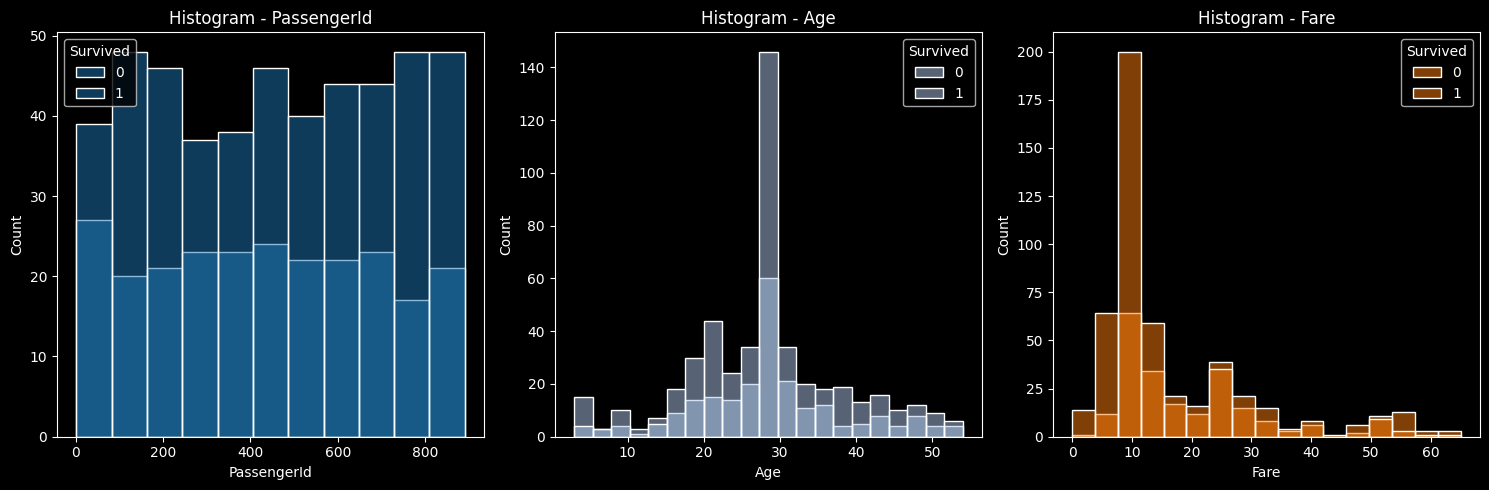

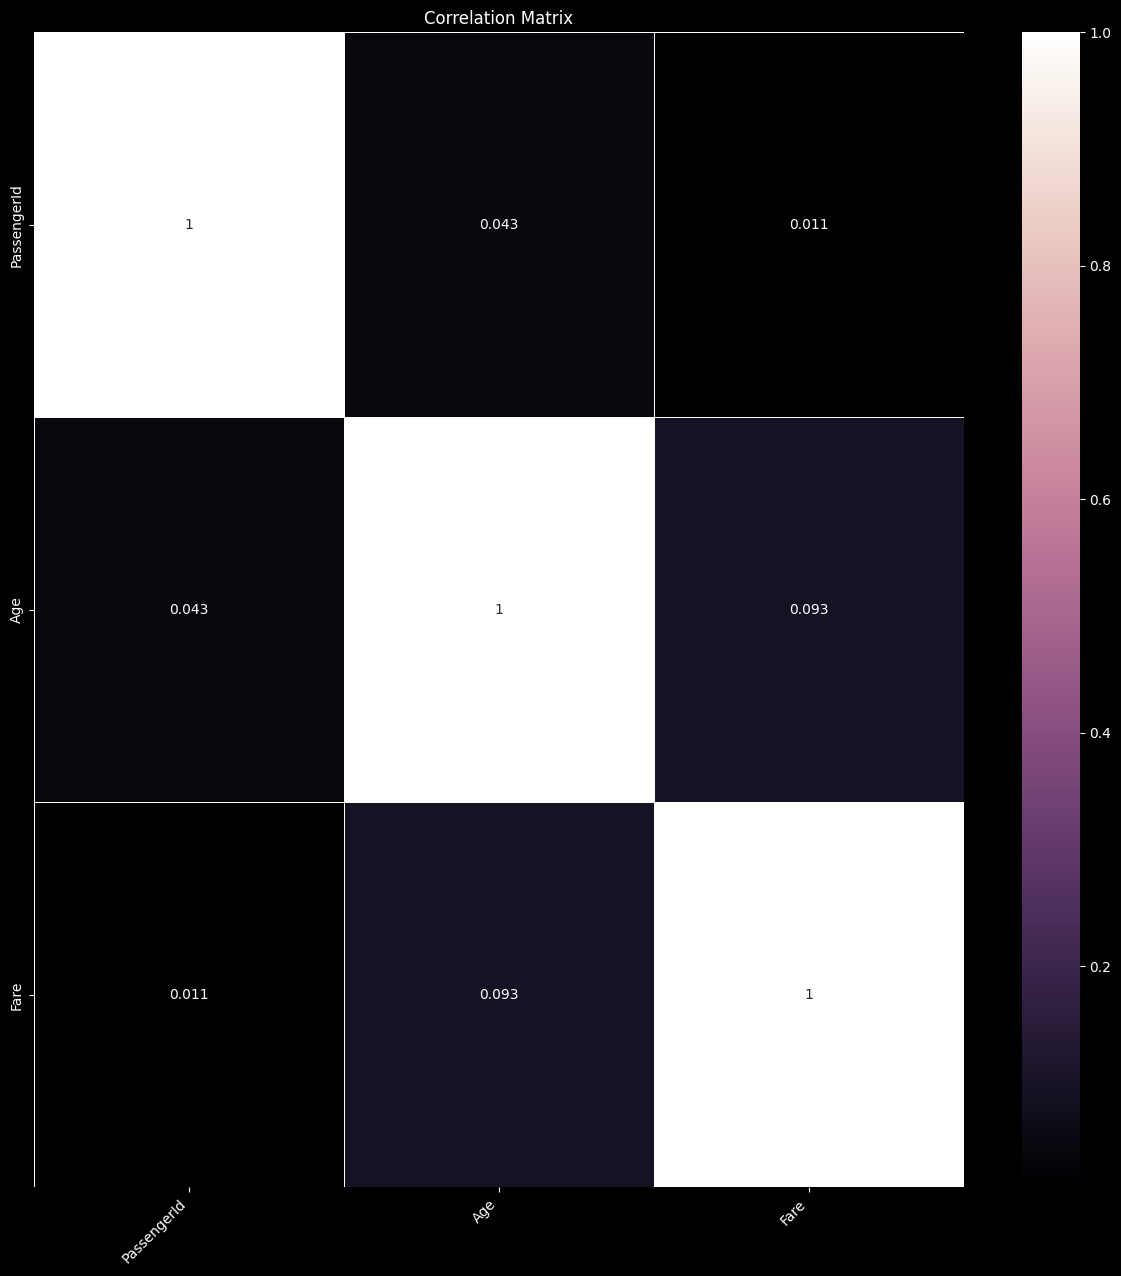

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

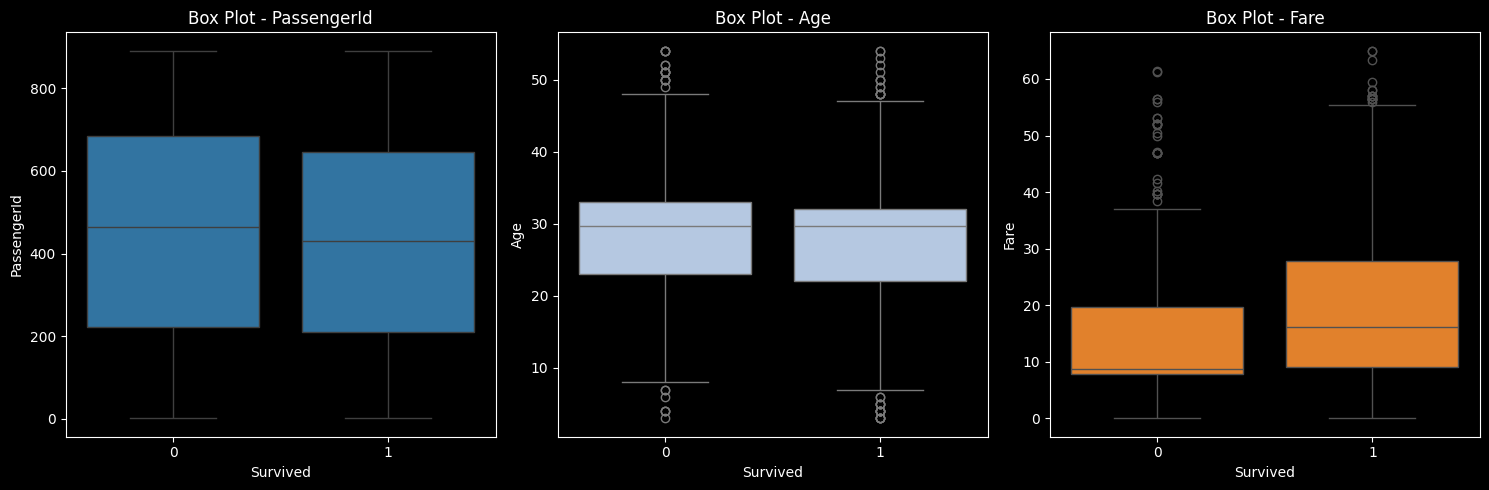

In [13]:
# Various visualizations
mkyz.visualize(data, graphics='histogram')
mkyz.visualize(data, graphics='corr')
mkyz.visualize(data, graphics='box')

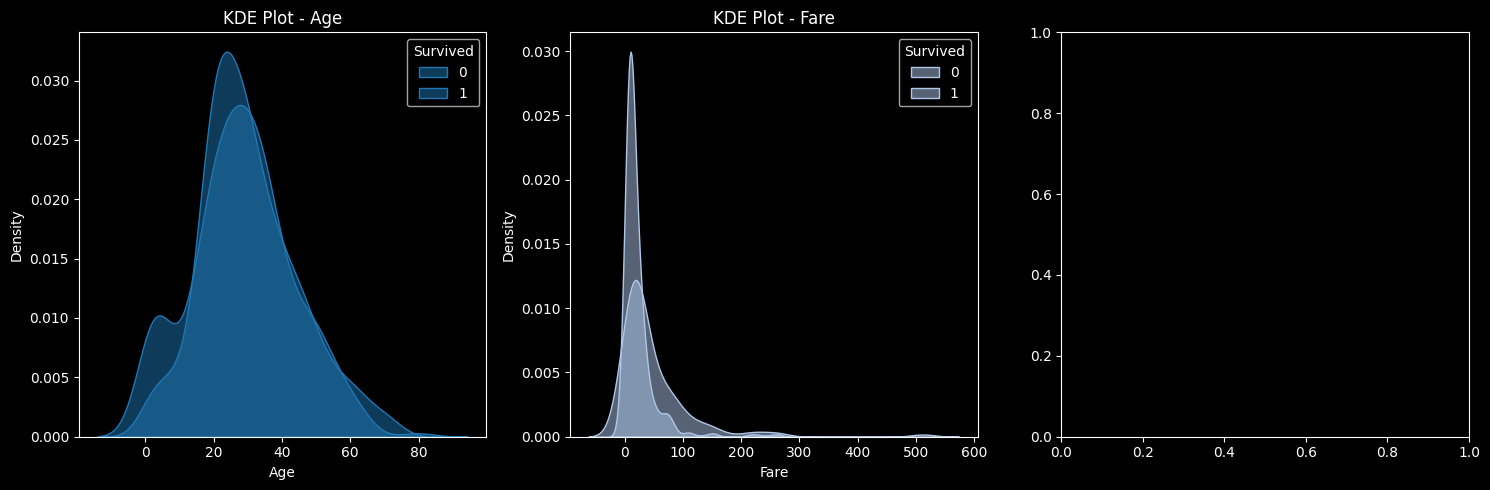

In [14]:
# Yeni Özellik: DataFrame ile doğrudan görselleştirme
# (Tuple açmanıza gerek kalmadan)
df_raw = mkyz.load_data('data/titanic.csv')

mkyz.visualize(
    data=df_raw, 
    target_column='Survived', 
    graphics='kde',
    numerical_columns=['Age', 'Fare'], # İsteğe bağlı, vermezseniz otomatik algılar
    categorical_columns=['Sex', 'Pclass'] # İsteğe bağlı
)

---

## Complete Example

Here is a complete end-to-end example using the Titanic dataset.

In [ ]:
import mkyz

# 1. Prepare data
data = mkyz.prepare_data('data/titanic.csv', target_column='Survived')
X_train, X_test, y_train, y_test, df, target, num_cols, cat_cols = data

# 2. Auto-train and find best model
best_model = mkyz.auto_train(data, task='classification')



# 3. Evaluate with cross-validation
results = mkyz.cross_validate(best_model, X_train, y_train, cv='stratified')
print(f"CV Accuracy: {results['mean_test_score']:.4f}")

# 4. Generate report
report = mkyz.ModelReport(best_model, X_test, y_test, task='classification')
report.generate()
report.export_html('titanic_report.html')

# 5. Save model
mkyz.save_model(best_model, 'titanic_model')

print("Done! Check titanic_report.html for results.")

INFO:mkyz.data_processing:First 5 rows of the dataset:
INFO:mkyz.data_processing:   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803 

Starting training of 7 models...

Model 'rf' training started.

Model 'rf' training completed.

Model 'lr' training started.

Model 'lr' training completed.

Model 'svm' training started.

Model 'svm' training completed.

Model 'knn' training started.

Model 'knn' training completed.

Model 'dt' training started.

Model 'dt' training completed.

Model 'nb' training started.

Model 'nb' training completed.

Model 'gb' training started.

Model 'gb' training completed.

                                              Model Training Results                                               
        ╷        ╷                   ╷               ╷                                                             
  Model │ Score  │ Training Time (s) │ Best CV Score │ Parameters                                                  
 ═══════╪════════╪═══════════════════╪═══════════════╪════════════════════════════════════════════════════════════ 
  rf    │ 0.8207 │ 0.38              │ N/A           │ bootstrap=True, ccp_alpha=0.0, class_weight=None,           
        │        │                   │               │ criterion=gini, max_depth=None, max_features=sqrt,          
        │        │                   │               │ max_leaf_nodes=None, max_samples=None,                      
        │        │                   │               │ min_impurity_decrease=0.0, min_samples_leaf=1,              
        │        │                   │               │ min_samples_split=2, min_weight_fraction_leaf=0.0,          
        │        │                   │               │ monotonic_cst=None, n_estimators=100, n_jobs=None,          
        │        │                   │               │ oob_score=False, random_state=None, verbose=0,              
        │        │                   │               │ warm_start=False                                            
  lr    │ 0.8138 │ 0.06              │ N/A           │ C=1.0, class_weight=None, dual=False, fit_intercept=True,   
        │        │                   │               │ intercept_scaling=1, l1_ratio=0.0, max_iter=100,            
        │        │                   │               │ n_jobs=None, penalty=deprecated, random_state=None,         
        │        │                   │               │ solver=lbfgs, tol=0.0001, verbose=0, warm_start=False       
  svm   │ 0.7586 │ 0.51              │ N/A           │ C=1.0, break_ties=False, cache_size=200,                    
        │        │                   │               │ class_weight=None, coef0=0.0, decision_function_shape=ovr,  
        │        │                   │               │ degree=3, gamma=scale, kernel=rbf, max_iter=-1,             
        │        │                   │               │ probability=False, random_state=None, shrinking=True,       
        │        │                   │               │ tol=0.001, verbose=False                                    
  knn   │ 0.7655 │ 8.62              │ N/A           │ algorithm=auto, leaf_size=30, metric=minkowski,             
        │        │                   │               │ metric_params=None, n_jobs=None, n_neighbors=5, p=2,        
        │        │                   │               │ weights=uniform                                             
  dt    │ 0.8000 │ 0.07              │ N/A           │ ccp_alpha=0.0, class_weight=None, criterion=gini,           
        │        │                   │               │ max_depth=None, max_features=None, max_leaf_nodes=None,     
        │        │                   │               │ min_impurity_decrease=0.0, min_samples_leaf=1,              
        │        │                   │               │ min_samples_split=2, min_weight_fraction_leaf=0.0,          
        │        │                   │               │ monotonic_cst=None, random_state=None, splitter=best        
  nb    │ 0.4207 │ 0.04              │ N/A           │ priors=None, var_smoothing=1e-09                            
  gb    │ 0.7931 │ 0.84              │ N/A           │ ccp_alpha=0.0, criterion=friedman_mse, init=None,           
        │        │                   │               │ learning_rate=0.1, loss=log_loss, max_depth=3,              
        │        │                   │               │ max_features=None, max_leaf_nodes=None,                     
        │        │                   │               │ min_impurity_decrease=0.0, min_samples_leaf=1,              
        │        │                   │               │ m

Best Model: rf

Score: 0.8207

Training Time: 0.38 seconds

Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 
'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 
'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 
'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

CV Accuracy: 0.8194
Done! Check titanic_report.html for results.
